# TD9 - Nhận diện khuôn mặt một số ca sĩ Việt Nam 

# Giới thiệu

Trong TD này ta tiếp tục sử dụng OpenCV trên Python để nhận diện khuôn mặt một số ca sĩ Việt Nam thông qua hình ảnh chụp chính diện của họ thông qua Support Vector Machine.

Bố cục TD như sau
- Thông qua phương pháp Haar-Cascade, trích xuất khuôn mặt của ca sĩ trong hình ảnh.
- Cũng cùng phương pháp, trích xuất các thành phần của khuôn mặt. Trong phạm vi TD, ta chỉ trích xuất đôi mắt.
- Xây dựng các tập dữ liệu dựa trên khuôn mặt/đôi mắt của người trong ảnh
- Thực hiện huấn luyện và đánh giá với SVM tuyến tính và SVM đa thức
- Chọn các biến quan trọng để giảm số chiều bài toán.

Dữ liệu của bài toán được download tại đây
https://drive.google.com/drive/u/0/folders/14qdG6Txe0osUvTEbFjnxrqqfUk6dTsxR

Trong đó bạn cần sử dụng các hình ảnh trong `RawData/face/format2`

Bạn cần hoàn thành các hàm/method trong file `SingerClassification.py`. File `Constants.py` được sử dụng để import cho `SingerClassification.py`, gồm các hằng số được định nghĩa trước có ý nghĩa như dưới đây.

In [1]:
# -*- coding: utf-8 -*-

# Thư mục chứa các hình ảnh gốc sẽ được sử dụng
RAW_IMAGE_FOLDER = "RawData/face/format2"

# Thư mục chứa các hình ảnh được copy, tập trung và đổi tên
IMAGE_FOLDER = "ImageFolder"

# Thư mục chứa các file text lưu trích xuất khuôn mặt, đôi mắt dưới dạng vector số, output của phần 1
TEXT_DATA_FOLDER = "TextData"

# Định dạng hình ảnh
EXTENSION = ".png"

# File Haar cascade của khuôn mặt
HAARCASCADE_FRONTALFACE_DEFAULT = "Configuration/haarcascade_frontalface_default.xml"

# File Haar cascade của đôi mắt
HAARCASCADE_EYE_DEFAULT = "Configuration/haarcascade_eye.xml"

# Hằng số kiểm tra xem khuôn mặt có được chụp ở tư thế trực diện không
# Khuôn mặt được xem là có tư thế trực diện nếu tâm mắt trái và tâm mắt phải có tung độ không cách nhau quá 3 pixel
HORIZONTAL_CHECK = 3

# File text lưu trích xuất khuôn mặt, đôi mắt dưới dạng vector số, output của phần 1
FACES_DATA = "TextData/Faces.csv"
EYES_DATA = "TextData/Eyes.csv"

# Chuẩn hoá tên các ca sĩ từ thư mục hình ảnh gốc
SINGER_NAME_DICTIONARY = {
    "bao thy" : "BaoThy",
    "chi pu": "ChiPu",
    "dam vinh hung": "DamVinhHung",
    "dan truong": "DanTruong",
    "ha anh tuan": "HaAnhTuan",
    "ho ngoc ha": "HoNgocHa",
    "huong tram": "HuongTram",
    "lam truong": "LamTruong",
    "my tam": "MyTam",
    "No phuoc thing": "NooPhuocThinh",
    "son tung": "SonTung",
    "tuan hung": "TuanHung"
}

# Đánh số thứ tự tên các ca sĩ
SINGER_INDEX_DICTIONARY = {
    "BaoThy": 0,
    "ChiPu": 1,
    "DamVinhHung": 2,
    "DanTruong": 3,
    "HaAnhTuan": 4,
    "HoNgocHa": 5,
    "HuongTram": 6,
    "LamTruong": 7,
    "MyTam": 8,
    "NooPhuocThinh": 9,
    "SonTung": 10,
    "TuanHung": 11
}

# Sau khi xử lí các hình ảnh và sắp xếp theo thứ tự ABC, các hình ảnh có thứ tự 0 đến 220 sẽ thuộc ca sĩ BaoThy
# v.v.
SINGER_IMAGE_RANGE = {
    "BaoThy": range(0, 221),
    "ChiPu": range(221, 521),
    "DamVinhHung": range(521, 676),
    "DanTruong": range(676, 811),
    "HaAnhTuan": range(811, 921),
    "HoNgocHa": range(921, 1109),
    "HuongTram": range(1109, 1327),
    "LamTruong": range(1327, 1407),
    "MyTam": range(1407, 1580),
    "NooPhuocThinh": range(1580, 1820),
    "SonTung": range(1820, 2020),
    "TuanHung": range(2020, 2226)
}

Đoạn code dưới đây import lời giải để minh hoạ.

In [2]:
from SingerClassification_Solution import *

# Phần 1 - Class `Face` - Trích xuất khuôn mặt và đôi mắt

## Bài 1. Copy và tập trung hình ảnh vào một thư mục

Thư mục chứa hình ảnh gốc nằm tại `RawData/face/format2` gồm 12 thư mục con như sau
<img src="F1.png"></img>

Tên các thư mục chính là các key của dict `SINGER_NAME_DICTIONARY` đã được định nghĩa trong `Constants.py`. Mỗi thư mục này chứa các hình ảnh ca sĩ có định dạng `.png` và kích thước `96 pixel x 96 pixel`. Tên các hình ảnh được đánh số không liên tục (vì có thể một số hình ảnh đã bị xoá do chất lượng không tốt hoặc ảnh không trực diện)

Để dễ làm việc về sau với các hình ảnh, ta muốn tập trung tất cả hình ảnh về một thư mục duy nhất và đặt lại tên để tên các hình ảnh có chỉ số được liên tục.

***Hãy viết hàm `prepareImageFolder(raw_image_folder, image_folder)` copy các hình ảnh trong tất cả các thư mục con (được đặt tên bằng các key trong `SINGER_NAME_DICTIONARY`) của `raw_image_folder` sang file `image_folder` và đặt lại tên các file dưới dạng `TenCaSi_Maso.png`, trong đó `TenCaSi` là value trong `SINGER_NAME_DICTIONARY`, các chỉ số bắt đầu từ 0. Ví dụ các hình ảnh từ thư mục `bao thy` sẽ có tên `BaoThy_0.png`, ..., `BaoThy_220.png`.***

Đoạn code sau giúp test hàm của bạn.

In [3]:
prepareImageFolder(RAW_IMAGE_FOLDER, IMAGE_FOLDER)

In [4]:
import pandas as pd
l = os.listdir(IMAGE_FOLDER) # Liệt kê thư mục mới
pd.DataFrame(l)

,0
0,BaoThy_0.png
1,BaoThy_1.png
2,BaoThy_10.png
3,BaoThy_100.png
4,BaoThy_101.png
5,BaoThy_102.png
6,BaoThy_103.png
7,BaoThy_104.png
8,BaoThy_105.png
9,BaoThy_106.png


Kết quả cần chứa 2227 hình ảnh với định dạng tên như liệt kê trên và như thư mục dưới đây:
<img src="F2.png"></img>

## Bài 2. Class `Face`

Ta xây dựng class `Face` sao cho mỗi instance của nó biểu diễn một hình ảnh, với trích xuất khuôn mặt và đôi mắt. Mỗi instance của class `Face` chứa các attribute sau:

- `image_path`: đường dẫn đến hình ảnh (ví dụ `ImageFolder/BaoThy_0.png`)
- `image_name`: tên hình ảnh, là tên file không chứa phần định dạng (ví dụ `BaoThy_0`)
- `gray_image`: numpy array biểu diễn hình ảnh dạng trắng đen (được gọi từ `cv2.imread(some_image, 0)`)
- `face_positions`, `eye_positions`: vị trí các khuôn mặt và con mắt trong hình ảnh (sẽ được tìm hiểu sau)
- `faces`, `eyes`: trích xuất các hình ảnh và con mắt, là một numpy array con của `gray_image`
- `normalized_faces`, `normalized_eyes`: numpy array biểu diễn khuôn mặt được chuẩn hoá về 64 x 64; con mắt được chuẩn hoá về 32 x 32.

Trước hết, ta xây dựng 3 attribute đầu tiên trong hàm `__init__`.

***Trong class `Face`, hãy viết method `__init__(self, image_path)` nhận đối số `image_path` là đường dẫn của hình ảnh và xây dựng instance thuộc class `Face` có các attributes `image_path`, `image_name`, `gray_image` như đã mô tả.***

Đoạn code dưới đây giúp test hàm của bạn.

In [5]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png")
print(face.gray_image)

[[204 204 203 ...  97  89  84]
 [205 204 204 ... 100  92  86]
 [205 205 205 ... 105  98  91]
 ...
 [217 216 217 ... 162 160 159]
 [215 215 215 ... 160 158 158]
 [215 215 214 ... 157 156 157]]


In [6]:
face.image_path

'ImageFolder/BaoThy_0.png'

In [7]:
face.image_name

'BaoThy_0'

## Bài 3. Vẽ hình bằng `matplotlib`

Phần này minh hoạ hình ảnh với `matplotlib`.

***Trong class `Face`, hãy viết method `draw(self, mode, index)` trong đó `mode` là một str, `index` là một int (mà ta chưa cần quan tâm trong bài này) sao cho nếu `mode` nhận giá trị `"full_gray"` thì khi gọi hàm `self.draw(mode = "full_gray")` sẽ trả lại dạng trắng đen của hình ảnh đang dùng.***

Đoạn code dưới đây giúp test hàm của bạn.

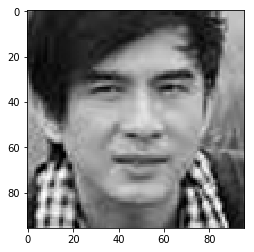

In [8]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png")
face.draw(mode = "full_gray")

## Bài 4. Xác định vị trí khuôn mặt và trích xuất khuôn mặt

Mặc dù các hình ảnh được xem là lấy khuôn mặt một cách trực diện, có những sự sai khác nhất định về vị trí tương đối của khuôn mặt trong hình ảnh, cũng như một số khuôn mặt không thực sự trực diện, chẳng hạn như hình dưới đây.

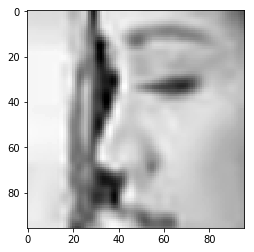

In [9]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png")
face.draw(mode = "full_gray")

Vì vậy, ta sử dụng phương pháp Haar Feature-based Cascade để "trích xuất" gương mặt theo phương pháp tương đồng giữa 1 zone hình ảnh với thác Haar tương ứng. Bạn có thể xem chi tiết về phương pháp và cách dùng ở đây: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html#cascadeclassifier-detectmultiscale

***Trong class `Face`, hãy viết method `detectFaces(self)` tìm tất cả các bộ `(x, y, w, h)` xác định vị trí khuôn mặt như output của `detectMultiScale` trong cv2 (tức `(x, y), (x + w, y), (x, y + h), (x + w, y + h)` sẽ là toạ độ 4 đỉnh của vùng khuôn mặt) và gán vào attribute `self.face_positions` array tất cả các bộ 4 tìm được. Hình ảnh xác định được `N` khuôn mặt thì array sẽ có chiều `N x 4`***.

Bạn có thể sử dụng `scaleFactor = Face.HAAR_SCALE_FACTOR, minNeighbors = Face.HAAR_MIN_NEIGHBORS, minSize = Face.HAAR_MIN_SIZE` cho hàm `detectMultiScale` và file `Face.HAARCASCADE_FRONTALFACE` cho cascade của khuôn mặt.

Đoạn code dưới đây giúp test hàm của bạn.

In [10]:
face = Face(IMAGE_FOLDER + "/BaoThy_10.png") # Cần ra 1 khuôn mặt, array có dạng 4 x 1
face.face_positions

array([[11,  5, 74, 74]], dtype=int32)

In [11]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png") # Cần ra 0 khuôn mặt, array có dạng 4 x 0 = 0
face.face_positions

()

***Tiếp theo, cũng trong method `detectFaces(self)`, gán các numpy array con của `self.gray_image` biểu diễn khuôn mặt tương ứng vào attribute `faces` dưới dạng 1 list. Hình ảnh xác định được bao nhiêu khuôn mặt thì list sẽ có bấy nhiêu phần tử, mỗi phần tử là một array.***

Đoạn code dưới đây giúp test hàm của bạn.

In [12]:
face = Face(IMAGE_FOLDER + "/BaoThy_10.png") 
face.faces # List chứa 1 phần tử: 1 array 74 x 74

[array([[ 29,  32,  26, ...,  99, 110, 113],
        [ 29,  31,  27, ...,  99, 114, 103],
        [ 27,  28,  29, ..., 104, 108, 107],
        ...,
        [ 15,  33,  26, ...,  14,  16,  22],
        [ 28,  44,  32, ...,  13,  15,  20],
        [ 55,  55,  46, ...,  13,  14,  18]], dtype=uint8)]

In [13]:
face = Face(IMAGE_FOLDER + "/BaoThy_0.png") 
face.faces # List chứa 0 phần tử

[]

***Cuối cùng, thêm vào method `draw(self, mode, index)` đã viết ở bài 3 để khi `mode` nhận giá trị `"face"` thì kết quả nhận được là biểu diễn hình ảnh của trích xuất khuôn mặt thứ `index` trong list `self.faces`, còn nếu `mode` nhận giá trị là `face_marked` thì kết quả là toàn bộ hình ảnh, nhưng phần khuôn mặt được trích xuất được đánh dấu (chẳng hạn bằng cách đóng khung)***

Đoạn code dưới đây lặp lại bài 3 khi `mode="full_gray"`

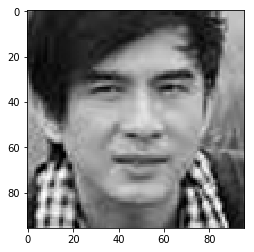

In [14]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "full_gray") 

Đoạn code dưới đây minh hoạ khi `mode="face"`

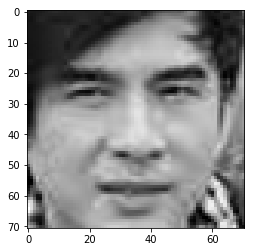

In [15]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "face", index = 0) 

Đoạn code dưới đây đánh dấu (đóng khung) khuôn mặt trên hình gốc

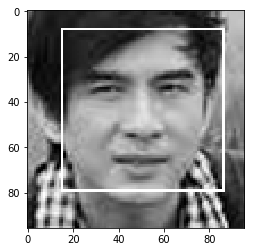

In [16]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "face_marked", index = 0) 

## Bài 5 - Chuẩn hoá kích thước khuôn mặt

***Áp dụng `cv2.resize()` đã thực hiện ở các TD trước, chuẩn hoá kích thước các khuôn mặt trong list `self.faces` về 64 x 64 pixel và lưu chúng vào list `self.normalized_faces` trong class `Face`.***

***Tiếp tục viết thêm vào method `draw(self, mode, index)` để khi `mode` nhận giá trị `"normalized_face"` thì nhận được trích xuất khuôn mặt được vẽ bởi matplotlib với kích thước 64 x 64.*** 

In [17]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.normalized_faces

[array([[ 28,  25,  25, ...,  37,  47, 102],
        [ 23,  22,  25, ...,  40,  44,  78],
        [ 20,  20,  26, ...,  45,  50,  64],
        ...,
        [117,  66,  40, ...,  75,  25,  57],
        [130, 101,  68, ...,  99,  21,  41],
        [171, 147, 112, ..., 147,  35,  15]], dtype=uint8)]

In [18]:
face.normalized_faces[0].shape # Kết quả là 64 x 64

(64, 64)

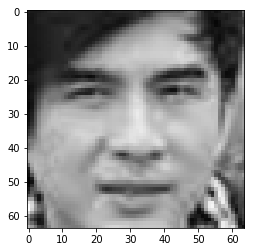

In [19]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png") 
face.draw(mode = "normalized_face", index = 0) # Kết quả là 1 hình có kích thước 64 pixel x 64 pixel

## Bài 6 - Xác định vị trí mắt và trích xuất mắt

***Trong class `Face`, hãy viết method `detectFaces(self)` tìm tất cả các bộ `(i, (x, y, w, h))` xác định vị trí mắt, trong đó `i` là số thứ tự khuôn mặt chứa mắt trong `self.faces`; còn `(x, y, w, h)` như output của `detectMultiScale` trong cv2 (tức `(x, y), (x + w, y), (x, y + h), (x + w, y + h)` sẽ là toạ độ 4 đỉnh của vùng mắt); và gán list tất cả các bộ `(i, (x, y, w, h))` tìm được vào attribute `self.eye_positions`. Hình ảnh xác định được bao nhiêu con mắt thì `self.eye_positions` sẽ là list sẽ có độ dài bấy nhiêu***.

Ví dụ với hình ảnh `DanTruong_10`, chỉ xác định được 1 mắt.

In [20]:
face = Face(IMAGE_FOLDER + "/DanTruong_10.png")
face.eye_positions

[(0, array([40, 13, 22, 22], dtype=int32))]

Với hình ảnh `DanTruong_4`, chỉ xác định được 2 mắt.

In [21]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eye_positions

[(0, array([37, 15, 22, 22], dtype=int32)),
 (0, array([ 9, 14, 24, 24], dtype=int32))]

Với hình ảnh `DanTruong_1`, thậm chí xác định được nhiều "mắt" hơn

In [22]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eye_positions

[(0, array([37, 15, 22, 22], dtype=int32)),
 (0, array([ 9, 14, 24, 24], dtype=int32))]

***Tiếp theo, cũng trong method `detectFaces(self)`, gán các bộ `(i, X)` vào `self.eyes` trong đó `X` là array con tương ứng các mắt đã xác định được.***

Các đoạn code dưới đây giúp test hàm của bạn

In [23]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.eyes # Cần là list 2 phần tử, mỗi phần tử là 1 bộ 1 số nguyên và 1 array)

[(0, array([[214, 216, 217, 217, 216, 214, 213, 213, 214, 213, 209, 210, 211,
          213, 214, 213, 213, 210, 208, 209, 195, 183],
         [218, 219, 218, 218, 216, 213, 209, 204, 209, 225, 209, 198, 204,
          201, 200, 197, 193, 195, 195, 194, 177, 172],
         [216, 213, 210, 210, 211, 212, 211, 207, 206, 211, 207, 192, 180,
          167, 166, 167, 155, 160, 160, 146, 131, 140],
         [210, 206, 203, 204, 206, 205, 200, 195, 182, 171, 177, 166, 142,
          122, 130, 143, 136, 121, 112, 105,  98, 105],
         [199, 198, 199, 200, 197, 185, 173, 165, 147, 124, 112, 103,  94,
           87,  89, 103, 107,  90,  80,  84,  78,  74],
         [191, 194, 197, 195, 184, 163, 140, 127, 115,  96,  67,  66,  72,
           70,  63,  72,  89,  82,  80,  78,  62,  47],
         [190, 195, 195, 185, 167, 141, 120, 107, 101,  95,  82,  89,  91,
           82,  70,  74,  87,  81,  74,  72,  75,  66],
         [194, 195, 187, 169, 148, 130, 121, 120, 120, 125, 137, 145, 132,
     

***Cuối cùng, thêm vào method `draw(self, mode, index)` đã viết ở bài 3 để khi `mode` nhận giá trị `"eye"` thì kết quả nhận được là biểu diễn hình ảnh của trích xuất mắt thứ `index` trong list `self.eyes`, còn nếu `mode` nhận giá trị là `eye_marked` thì kết quả là toàn bộ hình ảnh, nhưng phần mắt được trích xuất được đánh dấu (chẳng hạn bằng cách đóng khung)***

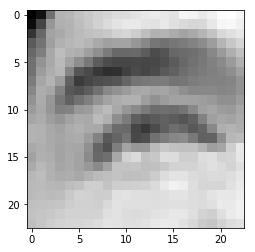

In [24]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye", index = 0)

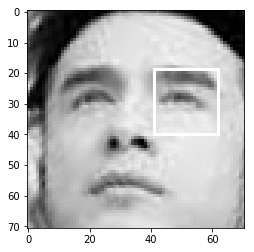

In [25]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye_marked", index = 1)

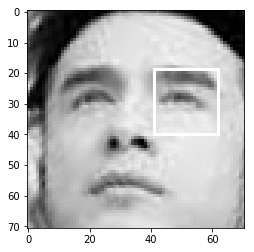

In [28]:
face = Face(IMAGE_FOLDER + "/DanTruong_1.png")
face.draw(mode="eye_marked", index = 2) # Trường hợp phát hiện nhiều mắt trong cùng 1 zone

## Bài 7 - Chuẩn hoá kích thước mắt

***Áp dụng `cv2.resize()` đã thực hiện ở các TD trước, chuẩn hoá kích thước các khuôn mặt trong list `self.eyes` về 32 x 32 pixel và lưu chúng vào attribute `self.normalized_eyes` dưới dạng 1 list `(i, X)` như `self.eyes`, nhưng `X` là các numpy array 32 x 32.***

***Tiếp tục viết thêm vào method `draw(self, mode, index)` để khi `mode` nhận giá trị `"normalized_eye"` thì nhận được trích xuất mắt thứ `index` được vẽ bởi matplotlib với kích thước 32 x 32.*** 

In [30]:
face = Face(IMAGE_FOLDER + "/DanTruong_4.png")
face.normalized_eyes

[array([[214, 215, 216, ..., 198, 189, 183],
        [216, 217, 217, ..., 189, 182, 177],
        [218, 217, 217, ..., 170, 166, 165],
        ...,
        [212, 208, 202, ..., 205, 203, 201],
        [213, 208, 202, ..., 202, 200, 199],
        [215, 209, 202, ..., 201, 199, 197]], dtype=uint8),
 array([[173, 172, 177, ..., 205, 205, 205],
        [175, 174, 179, ..., 210, 210, 212],
        [180, 179, 181, ..., 211, 213, 217],
        ...,
        [200, 200, 200, ..., 188, 190, 193],
        [201, 201, 200, ..., 187, 190, 192],
        [200, 201, 201, ..., 194, 195, 195]], dtype=uint8)]

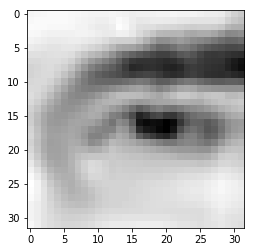

In [31]:
face.draw(mode = "normalized_eye", index = 0) # Mắt phải, kích thước 32 x 32

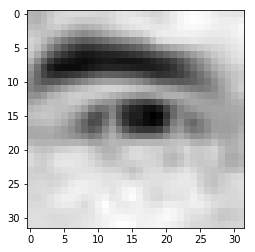

In [32]:
face.draw(mode = "normalized_eye", index = 1) # Mắt trái, kích thước 32 x 32